# Packages & functions

In [49]:
env = 'pc' # 'colab' # 'pc'  # 'colab'

using_gpu = False

train_percentage = 0.07  # how much of train set we will use
val_percentage = 0.07
test_percentage = 0.07

saving_models = True
save_dir = 'C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels/2022-01-23/'

In [50]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/image_generator/'
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Utils.py',
             
             'BNModel.py',
             'CNNModel.py',
             'DropoutModel.py',
             'InceptionModel.py',
             'Model.py',
             'ResNetModel.py'
    ]
    url_dict = {file: path + file for file in files}
    download_files(url_dict)

In [51]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [52]:
# Models
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir
from datetime import date

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [53]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import Model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,
        CNNModel,
        BNModel,
        DropoutModel,
        Model,
        ResNetModel,
        InceptionModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel

In [54]:
DataProps = DataProperties(environment = env)

# Data download

## Paths download

In [55]:
assert isdir(DataProps.train_data_path) == True
assert isdir(DataProps.test_data_path) == True

In [56]:
def calc_files(directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        # print('Searching in : ',base)
        for _ in files:
            total_files += 1
    return total_files

In [57]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [58]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [59]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

Text(0, 0.5, 'y')

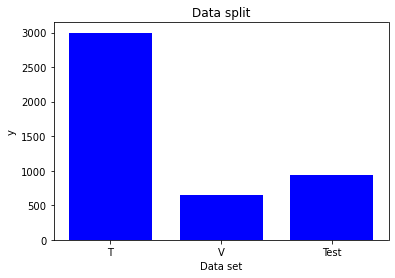

In [60]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

# Creating dataset

In [61]:
train_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - train_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

train_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)
print(f'Use {train_flow.n} images for train')

Found 300 images belonging to 3 classes.
Use 300 images for train


In [62]:
val_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - val_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

val_flow = train_generator.flow_from_directory(
    directory = DataProps.val_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',  # yes, training - we use val_split of data 
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

print(f'Use {val_flow.n} images for validation')

Found 66 images belonging to 3 classes.
Use 66 images for validation


In [63]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - test_percentage
    # other parameters
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

print(f'Use {test_flow.n} images for test')

Found 96 images belonging to 3 classes.
Use 96 images for test


In [64]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

# Visualizing dataset

(32, 300, 300, 3)


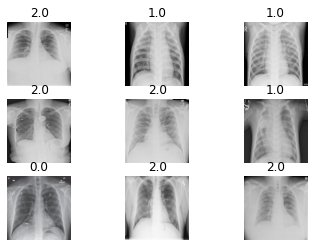

In [65]:
how_many_to_show = 9
for _ in range(1):
    batch, labels = train_flow.next()
    print(batch.shape)
    assert np.max(batch) <= 1.0
    visualize(batch, labels, how_many_to_show)

# Prepare before training

In [66]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

what_to_monitor = 'val_loss'
validation_data = val_flow
validation_steps = validation_steps

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

print(f'Train steps: {train_steps}')
print(f'Val steps: {validation_steps}')

Train steps: 9
Val steps: 2


In [67]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

# CNN architecture

## Fit

In [111]:
cnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'CNN' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

cnn_model = CNNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = cnn_checkpoint_callback
)
cnn_model.construct_model()
cnn_model.compile_model()

In [108]:
params = {
    'model': cnn_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, cnn_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        cnn_history = fit_(**params)
else:
    cnn_history = fit_(**params)

ERROR:tensorflow:Couldn't match files for checkpoint C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-23/CNN\.
Epoch 1/500
3/9 [=========>....................] - ETA: 7s - loss: 0.4372 - acc: 0.8684 

KeyboardInterrupt: 

In [110]:
print(f'dir: {save_dir + cnn_model.name + "/"}')
if saving_models:
    cnn_model.save_model(
        dir = save_dir + cnn_model.name + '/'
    )

dir: C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels/2022-01-23/CNN/


# Batch normalization

## Fit

In [ ]:
bn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'BN' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

bn_model = BNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = bn_checkpoint_callback
)
bn_model.construct_model()
bn_model.compile_model()

# print(cnn_model.model.summary())

In [105]:
params = {
    'model': bn_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, bn_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        bn_history = fit_(**params)
else:
    bn_history = fit_(**params)

NameError: name 'bn_model' is not defined

In [ ]:
print(f'dir: {save_dir + bn_model.name + "/"}')
if saving_models:
    bn_model.save_model(
        dir = save_dir + bn_model.name + '/'
    )

## Evaluation

In [ ]:
bn_model.model.evaluate(
    val_flow,
    steps = validation_steps
)

  18/4086 [..............................] - ETA: 31:32 - loss: 2.9067 - acc: 0.0556

KeyboardInterrupt: 

In [ ]:
test_flow.reset()
cnn_model.model.evaluate(
    test_flow,
    steps = test_steps
)

288/288 [==============================] - 6s 21ms/step - loss: 1.1814 - acc: 0.3368


[1.1814476393370166, 0.33680555]

# Dropout model

## Fit

Dropout / Batch normalization disharmony

In [102]:
dropout_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'Dropout' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

dropout_model = DropoutModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = dropout_checkpoint_callback
)

dropout_model.construct_model()
dropout_model.compile_model()

In [103]:
params = {
    'model': dropout_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, dropout_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        dropout_history = fit_(**params)
else:
    dropout_history = fit_(**params)

Epoch 1/500
9/9 [==============================] - 15s 2s/step - loss: 1.7814 - acc: 0.3403 - val_loss: 1.0979 - val_acc: 0.3438
Epoch 2/500
9/9 [==============================] - 12s 1s/step - loss: 1.0012 - acc: 0.6008 - val_loss: 1.0695 - val_acc: 0.5781
Epoch 3/500
9/9 [==============================] - 15s 2s/step - loss: 0.6663 - acc: 0.7201 - val_loss: 1.2481 - val_acc: 0.6094
Epoch 4/500
9/9 [==============================] - 13s 1s/step - loss: 0.5725 - acc: 0.7425 - val_loss: 0.7360 - val_acc: 0.6406
Epoch 5/500
9/9 [==============================] - 13s 1s/step - loss: 0.4981 - acc: 0.7761 - val_loss: 0.4338 - val_acc: 0.7969
Epoch 6/500
9/9 [==============================] - 13s 1s/step - loss: 0.3990 - acc: 0.8284 - val_loss: 0.5329 - val_acc: 0.8438
Epoch 7/500
9/9 [==============================] - 14s 2s/step - loss: 0.3302 - acc: 0.8750 - val_loss: 0.3737 - val_acc: 0.8281
Epoch 8/500
9/9 [==============================] - 13s 1s/step - loss: 0.2602 - acc: 0.8769 - val

In [104]:
print(f'dir: {save_dir + dropout_model.name + "/"}')
if saving_models:
    dropout_model.save_model(
        dir = save_dir + dropout_model.name + '/'
    )

## Evaluation

In [ ]:
dropout_model.model.evaluate(
    val_flow,
    steps = validation_steps
)

128/128 [==============================] - 91s 711ms/step - loss: 1.0097 - acc: 0.5705


[1.0096674505621195, 0.5704846]

# Residual network

In [ ]:
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'ResNet' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

resnet_model = ResNetModel(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = resnet_checkpoint_callback
)
resnet_model.construct_model()
resnet_model.compile_model()

In [ ]:
params = {
    'model': resnet_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, resnet_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        resnet_history = fit_(**params)
else:
    resnet_history = fit_(**params)

Epoch 1/3
6/6 [==============================] - 335s 56s/step - loss: 1.5883 - acc: 0.4083
Epoch 2/3


KeyboardInterrupt: 

In [ ]:
print(f'dir: {save_dir + resnet_model.name + "/"}')
if saving_models:
    resnet_model.save_model(
        dir = save_dir + resnet_model.name + '/'
    )

# Inception network

In [ ]:
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'Inception' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

inception_model = InceptionModel(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = inception_checkpoint_callback
)
inception_model.construct_model()
inception_model.compile_model()

In [ ]:
params = {
    'model': inception_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, inception_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        resnet_history = fit_(**params)
else:
    resnet_history = fit_(**params)

Epoch 1/3
6/6 [==============================] - 274s 46s/step - loss: 1.1140 - acc: 0.3195
Epoch 2/3
6/6 [==============================] - 248s 41s/step - loss: 1.0836 - acc: 0.4142
Epoch 3/3
2/6 [=========>....................] - ETA: 3:24 - loss: 1.0709 - acc: 0.4062

In [ ]:
print(f'dir: {save_dir + inception_model.name + "/"}')
if saving_models:
    inception_model.save_model(
        dir = save_dir + inception_model.name + '/'
    )

# Models evaluation

## Models reload

In [112]:
# Deleting and re-loading everything
models = {
    'CNN': cnn_model,
    # rest of models
}

for m in models.values():
    del m

In [113]:
models['CNN'] = CNNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = cnn_checkpoint_callback
)

# Rest of models

In [114]:
for name, model in models.items():
    model.construct_model()
    model.compile_model()
    model.model.load_weights(save_dir + model.name + '/' + f'{model.name}.h5')

In [118]:
cnn = models['CNN']

## Test flow performance

In [ ]:
# cnn_model.model.evaluate(
#     val_flow,
#     steps = validation_steps
# )

In [134]:
def collect_metrics(models_dict, data_flow, data_steps):
    res_metrics = dict(
        losses = {},
        accuracies = {},
        F1s = {},
        precisions = {},
        recalls = {}
    )

    for name, model in models_dict.items():
        data_flow.reset()
        eval_res = model.model.evaluate(
           data_flow,
           steps = data_steps
        )

        res_metrics['losses'][name] = eval_res[0]  # loss
        res_metrics['accuracies'][name] = eval_res[1]  # accuracy


        data_flow.reset()
        metrics = model.evaluate_metrics(
            data_flow,
            data_steps
        )

        res_metrics['F1s'][name] = metrics['F1']
        res_metrics['precisions'][name] = metrics['Precision']
        res_metrics['recalls'][name] = metrics['Recall']

        return res_metrics

In [ ]:
test_flow.reset()
Y_pred = cnn_model.flow_predict(
    test_flow,
    test_steps
)

plot_confusion_matrix(
    Y_true = test_flow.classes, 
    Y_pred = Y_pred,
    class_indices = test_flow.class_indices
)

In [ ]:
plot_history(
    history = cnn_history.history,
    metrics_name = 'acc',
    plot_validation = True
)

## Layers interpretation

In [ ]:
visualize_kernel_work(
    model = cnn_model.model, 
    n_layer = 0, 
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

In [ ]:
visualize_kernel_work(
    model = cnn_model.model, 
    n_layer = 2,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

## Number of parameters, learning time

In [ ]:
# model.summary() 